In [1]:
#
# Process-- we are going to first make a script that can convert from a given source DXF into 
# a DXF-AAMA file with just those blocks and entities selected and ordered
#
# Should be able to send these files to the cutter as-is for verification (and potentially their layout)
#
# Subsequent process to pull these files in and reposition them ourselves with a combined new layout
#

In [1]:
# Inputs for converting a single file
inputfilename = "../dxffiles/P-E-13,5-BS-Master-09.dxf"
inputfilename = "../dxffiles/F15-BS-01.dxf"
inputfilename = "../dxffiles/F15-TSF-Master-04.dxf"
inputfilename = "../dxffiles/F15-TSR-TSM-Master-04.dxf"

dmax = 0.2
cutlayers, penlayers = ["BSF-CUT-BOTH"], ['BSF-PLOT-PUMA']
cutlayers, penlayers = ["BSR-CUT-PUMA"], ['BSR-PLOT-PUMA']
cutlayers, penlayers = ['TSF-CUT'], ['TSF-PLOT']
cutlayers, penlayers = ['PATCH-NORM-CUT'], ['PATCH-NORM-PLOT']
cutlayers, penlayers = ['MYLAR-CUT'], []
cutlayers, penlayers = ['TSR-144-CUT'], ['TSR-144-PLOT']
cutlayers, penlayers = ['PATCH-CUT'], ['PATCH-PLOT']

#cutlayers, penlayers = ["BSM-CUT-BOTH"], ['BSM-PLOT-PUMA']
#cutlayers, penlayers = ["PATCH-OUTSIDE", "PATCH-INSIDE", "PATCH-MYLAR"], [ ]
outputfilename = "../dxffiles/aamaout/F15-TSF-TSM.dxf"
#outputfilename = "../dxffiles/aamaout/PATCHES.dxf"

import ezdxf
d = ezdxf.readfile(inputfilename)
print("layerspresent:", set(e.dxf.layer for e in d.entities))

d = ezdxf.readfile(inputfilename)
lwpolylines = [ e  for e in d.entities  if e.dxftype() == "LWPOLYLINE" ]
if lwpolylines:
    print("exploding %d lwpolylines" % len(lwpolylines))
    for e in lwpolylines:
        e.explode()


layerspresent: {'TSR-144-PLOT', 'PATCH-PLOT', 'TSM-144-CUT', 'TSM-150-CUT', 'TSM-150-PLOT', '0', 'CONSTRUCTION', 'TSR-150-CUT', 'TSR-144-CUT', 'TSM-144-PLOT', 'REFERENCE', 'HISTORY', 'TSR-150-PLOT', 'PATCH-CUT'}


In [2]:
import ezdxf
from dxfgrouping import filterlayerelements, makemergevertset, linearizeelement

cutelements = filterlayerelements(d, cutlayers)
penelements = filterlayerelements(d, penlayers)


In [75]:
s = [e  for e in cutelements  if e.dxftype() == "SPLINE" ]
for l in s:
    print(l.knots)
#ps = linearizeelement(s[1])
#plt.plot([p.x  for p in ps], [p.y  for p in ps], color=c)


TypeError: unsupported operand type(s) for -: 'array.array' and 'float'

In [63]:
e.dxfattribs()
e.knots
list(e.control_points)

[(4957.418247531769, -2579.798402875387, 0.0),
 (4936.462581495384, -2577.650858980297, 0.0),
 (4915.487999172654, -2575.509676557712, 0.0),
 (4845.078669766443, -2568.507768713401, 0.0),
 (4795.55195415239, -2563.888673469142, 0.0),
 (4725.985392571411, -2558.696931276307, 0.0),
 (4706.055251748987, -2557.357990928653, 0.0),
 (4669.854716412865, -2555.268099932075, 0.0),
 (4653.591793428406, -2554.454140926456, 0.0),
 (4626.506759595056, -2553.342531002053, 0.0),
 (4615.693205987176, -2552.963298812643, 0.0),
 (4583.231843304799, -2552.037698660171, 0.0),
 (4561.599340525317, -2551.706524860262, 0.0),
 (4518.364165871958, -2551.513917206623, 0.0),
 (4496.759857712352, -2551.652390669327, 0.0),
 (4431.990993214459, -2552.619059358197, 0.0),
 (4388.870496778448, -2553.99822275987, 0.0),
 (4309.96190043956, -2557.130692651694, 0.0),
 (4274.152539375438, -2558.783054748428, 0.0),
 (4238.397497539321, -2560.43273516752, 0.0)]

In [66]:
control_points = [(4957.418247531769, -2579.798402875387, 0.0),
                 (4936.462581495384, -2577.650858980297, 0.0),
                 (4915.487999172654, -2575.509676557712, 0.0),
                 (4845.078669766443, -2568.507768713401, 0.0),
                 (4795.55195415239, -2563.888673469142, 0.0),
                 (4725.985392571411, -2558.696931276307, 0.0),
                 (4706.055251748987, -2557.357990928653, 0.0),
                 (4669.854716412865, -2555.268099932075, 0.0),
                 (4653.591793428406, -2554.454140926456, 0.0),
                 (4626.506759595056, -2553.342531002053, 0.0),
                 (4615.693205987176, -2552.963298812643, 0.0),
                 (4583.231843304799, -2552.037698660171, 0.0),
                 (4561.599340525317, -2551.706524860262, 0.0),
                 (4518.364165871958, -2551.513917206623, 0.0),
                 (4496.759857712352, -2551.652390669327, 0.0),
                 (4431.990993214459, -2552.619059358197, 0.0),
                 (4388.870496778448, -2553.99822275987, 0.0),
                 (4309.96190043956, -2557.130692651694, 0.0),
                 (4274.152539375438, -2558.783054748428, 0.0),
                 (4238.397497539321, -2560.43273516752, 0.0)]
knots = [ 11.15408553650174, 11.15408553650174, 11.15408553650174, 11.15408553650174, 
          74.23420502916287, 74.23420502916287, 222.7026150874886, 222.7026150874886, 
          282.2279449301449, 282.2279449301449, 330.7025071372611, 330.7025071372611, 
          362.8838735013803, 362.8838735013803, 427.2466062296185, 427.2466062296185, 
          491.6093389578567, 491.6093389578567, 620.3348044143331, 620.3348044143331, 
          727.5504819217829, 727.5504819217829, 727.5504819217829, 727.5504819217829 ]
spline = ezdxf.math.BSpline(e.control_points, 4, knots)
list(spline.approximate(20))

[Vector(0.0, 0.0, 0.0),
 Vector(4932.270868637277, -2577.228284111336, 0.0),
 Vector(4895.970034827183, -2573.5687888503617, 0.0),
 Vector(4859.62882072182, -2570.0135132757214, 0.0),
 Vector(4823.245614135932, -2566.6168276524695, 0.0),
 Vector(4786.818783007199, -2563.4332925082867, 0.0),
 Vector(4750.346695265227, -2560.5174685223765, 0.0),
 Vector(4713.827717603061, -2557.9240476300015, 0.0),
 Vector(4677.260239360558, -2555.708086515024, 0.0),
 Vector(4640.64269844466, -2553.9247267913734, 0.0),
 Vector(4603.9736337466775, -2552.629292291884, 0.0),
 Vector(4567.289318455162, -2551.860505254489, 0.0),
 Vector(4530.62822148849, -2551.58304905639, 0.0),
 Vector(4493.993454755297, -2551.7415263989474, 0.0),
 Vector(4457.386051920786, -2552.280602952904, 0.0),
 Vector(4420.807491623915, -2553.1451227383745, 0.0),
 Vector(4384.259206603539, -2554.2802349448853, 0.0),
 Vector(4347.742627472115, -2555.631116815327, 0.0),
 Vector(4311.259180129036, -2557.1430487806683, 0.0),
 Vector(4274.8

In [ ]:
for t in [0, 11.15, 11.16, 50]:
    print(t, spline.point(t))


In [61]:
e.dxfattribs()

{'handle': '3D1',
 'layer': 'PATCH-CUT',
 'linetype': 'ByLayer',
 'color': 256,
 'lineweight': -1,
 'extrusion': Vector(0.0, 0.0, 0.0),
 'flags': 8,
 'degree': 3,
 'knot_tolerance': 1e-07,
 'control_point_tolerance': 1e-07,
 'owner': '1F'}

0 (0.0, 0.0, 0.0)
11.15 (0.0, 0.0, 0.0)
11.16 (4957.412353050275, -2579.7977988071066, 0.0)
50 (4918.681741381715, -2575.849117500832, 0.0)


In [81]:
e = s[1]
l = ezdxf.math.BSpline(e.control_points, e.dxfattribs()["degree"]+1, [k-e.knots[0]  for k in e.knots ], e.weights or None)
list(l.approximate(20))


[Vector(4957.418247531769, -2579.798402875387, 0.0),
 Vector(4921.700902474779, -2576.1547321455146, 0.0),
 Vector(4885.945479349098, -2572.5749701070977, 0.0),
 Vector(4850.150479071177, -2569.110755375718, 0.0),
 Vector(4814.314351605665, -2565.8140923608107, 0.0),
 Vector(4778.435538801117, -2562.737070605427, 0.0),
 Vector(4742.512482448056, -2559.931780563112, 0.0),
 Vector(4706.543624226108, -2557.450525559637, 0.0),
 Vector(4670.527434258341, -2555.3458882095083, 0.0),
 Vector(4634.462434506037, -2553.6705460650737, 0.0),
 Vector(4598.3483239609395, -2552.4773319365017, 0.0),
 Vector(4562.229322162533, -2551.794249777106, 0.0),
 Vector(4526.133615938611, -2551.5801471652176, 0.0),
 Vector(4490.063517317942, -2551.7821255520494, 0.0),
 Vector(4454.020107361584, -2552.3473700190707, 0.0),
 Vector(4418.004790952712, -2553.2232549877954, 0.0),
 Vector(4382.018934961901, -2554.3574244917677, 0.0),
 Vector(4346.063905206995, -2555.6975387799394, 0.0),
 Vector(4310.141062671154, -2557.

dmaxs-tail:  [0.013801958018743583, 0.013801958022529094, 0.01911316556174089]


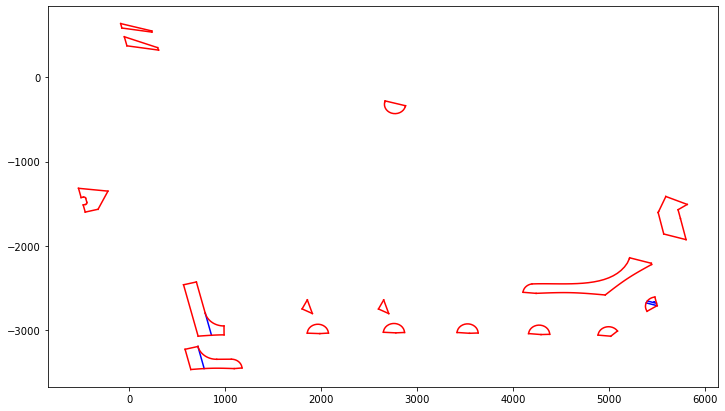

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,7))
for es, c in [(penelements, "blue"), (cutelements, "red")]:
    for e in es:
        ps = linearizeelement(e)
        plt.plot([p.x  for p in ps], [p.y  for p in ps], color=c)


smergevertset = makemergevertset(cutelements, 1.2)
def mergeverterror(mv):
    return max((mv.pt - me.pts[0 if me.bfore else -1]).magnitude  for me in mv.mergeedges)
highmergeerrors = [ mv.pt  for mv in smergevertset  if mergeverterror(mv) > 0.1 ]
plt.scatter([pt.x  for pt in highmergeerrors], [pt.y  for pt in highmergeerrors])

dmaxs-tail:  [6.245036057586848e-12, 1.0999348430804918e-11, 0.06873168711912457]
vertdegs: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2]
Component:  8 5 41
dmaxs-tail:  [3.6450773090749405e-12, 3.6699239967192685e-12, 3.712271306370825e-12]
vertdegs: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Component:  6 4 0
dmaxs-tail:  [2.2737367544323206e-13, 3.410605131648481e-13, 9.165725883006586e-13]
vertdegs: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Component:  3 0 0
dmaxs-tail:  [0.0, 3.410605131648481e-13, 9.165725883006586e-13]
vertdegs: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Component:  3 0 0
dmaxs-tail:  [0.0, 3.410605131648481e-13, 9.165725883006586e-13]
vertdegs: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Component:  3 0 0
dmaxs-tail:  [0.0, 3.410605131648481e-13, 9.165725883006586e-13]
vertdegs: [2, 2, 2, 2, 2, 2, 2]
Component:  3 0 0
dmaxs-tail:  [0.0, 3.410605131648481e-13, 9.16

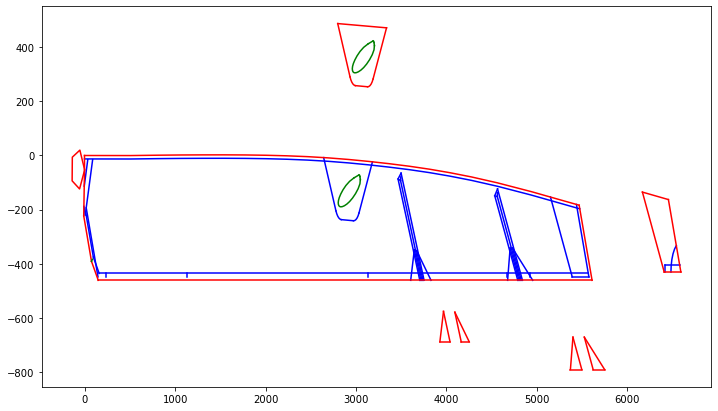

In [10]:
from dxfgrouping import getblockcomponent, dxfoutputblocks

lcutelements, lpenelements = cutelements, penelements
elementgroups = [ ]

while lcutelements:
    res = getblockcomponent(lcutelements, lpenelements, dmax)
    (outercutelements, outercutelementsdir) = res[0]
    (internalcutelements, internalpenelements) = res[1]
    (remainingcutelements, remainingpenelements) = res[2]
    elementgroups.append((outercutelements, outercutelementsdir, internalcutelements, internalpenelements))
    lcutelements, lpenelements = remainingcutelements, remainingpenelements
    print("Component: ", len(outercutelements), len(internalcutelements), len(internalpenelements))
    
plt.figure(figsize=(12,7))
xdisp = 0
for loutercutelements, loutercutelementsdir, linternalcutelements, linternalpenelements in elementgroups:
    for es, c in [(linternalpenelements, "blue"), (loutercutelements, "red"), (linternalcutelements, "green")]:
        for e in es:
            ps = linearizeelement(e)
            plt.plot([p.x+xdisp  for p in ps], [p.y  for p in ps], color=c)
    xdisp += 100

In [11]:

dxfoutputblocks(outputfilename, elementgroups)
